# Westcott $g_w$-factor

This `Notebook` uses the methodology outlined in the manuscript by Matters, et al., for the determination of Westcott $g_w$-factors based on neutron-capture cross sections extracted from the XML-formatted GNDS instance of the ENDF-B/VIII.1 neuturon library. This `Notebook` produces the figures and tables in the manuscript.

In [1]:
import westcott_gfactors as gw
import numpy as np
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

# Constants
v_0 = 2200 #thermal-neutron velocity, m/s
eV = 1.602189e-19 #J
kB = 1.38066e-23 #Boltzmann's constant, J/K
m_n = 1.00866501 *1.660566e-27 #neutron mass, kg

# Neutron capture data ingested from ENDF 8.1 via FUDGE (reference 'n-capture-gnds.py')
capture_data_PATH = "/Users/davidmatters/westcott/n-capture-gnds/capture_data"

In [2]:
# Isotopes for table, from various references
isotopes_vanSlujis = ['S36', 'Ag107', 'Ag109', 'Rh103', 'Nb93', 'In113', 'In115',\
                      'Sb121', 'Cs133', 'Eu151', 'Eu153', 'Gd152', 'Sm152', 'Tb159',\
                      'Lu175', 'Lu176', 'Hf174', 'Hf178', 'Hf179', 'Ta181', 'Re185',\
                      'Re187', 'Ir191', 'Ir193', 'Os190', 'Hg196', 'Au197', 'Yb168',\
                      'Tm169', 'Dy164', 'W186', 'Hg204', 'Th232', 'U238']
isotopes_Holden = ['Rh103', 'Cd113', 'In115', 'Xe135', 'Pm148', 'Sm149', 'Sm151',\
                   'Eu151', 'Eu152', 'Eu153', 'Eu154', 'Eu155', 'Gd155', 'Gd157',\
                   'Dy164', 'Lu175', 'Lu176', 'Hf177', 'Ta182', 'Re185', 'Re187',\
                   'Au197', 'Pa231', 'Pa233', 'U235', 'U238']
isotopes_Molnar = ['Kr83', 'Rh103', 'Cd113', 'In113', 'In115', 'Te123', 'Sm149', \
                   'Eu151', 'Eu153', 'Gd155', 'Gd157', 'Dy164', 'Er167', 'Lu175', \
                   'Lu176', 'Hf174', 'Hf177', 'Re187', 'Ir193', 'Au197']
isotopes_Pritychenko = ['Cd113', 'Xe135', 'Sm149', 'Eu151', 'Lu176', 'Ta182', 'Pu239', 'Am243']
isotopes_IAEA = ['Si30', 'S36', 'Ar36', 'Ar38', 'Kr83', 'Sr87', 'Rh103', 'Pd105',\
                 'Ag109', 'Cd111', 'Cd113', 'In113', 'In115', 'Sb121', 'Te123',\
                 'Xe124', 'Ba132', 'Cs133', 'Ce138', 'Nd143', 'Sm149', 'Sm152',\
                 'Eu151', 'Eu153', 'Gd155', 'Gd157', 'Dy156', 'Dy158', 'Dy160',\
                 'Dy161', 'Dy162', 'Dy163', 'Dy164', 'Er167', 'Tm169', 'Yb168',\
                 'Hf174', 'Hf176', 'Lu175', 'Lu176', 'Hf177', 'Hf178', 'Hf179',\
                 'Hf180', 'Ta180', 'Ta181', 'W180', 'W182', 'Re185', 'Re187',\
                 'Os186', 'Os187', 'Ir191', 'Ir193', 'Au197', 'Hg196', 'Hg199',\
                 'Th232', 'U234', 'U235']
isotopes_IAEA_resonance_table = ['Si30', 'S36', 'Ar36', 'Ar38', 'Kr83', 'Sr87',\
                                 'Rh103', 'Pd105','Ag107', 'Ag109', 'Nb93',\
                                 'Cd111', 'Cd113', 'In113', 'In115','Sb121',\
                                 'Te123', 'Xe124', 'Ba132', 'Cs133', 'Ce138',\
                                 'Nd143','Pm148', 'Sm149', 'Sm151', 'Sm152',\
                                 'Eu151', 'Eu152', 'Eu153','Eu154', 'Eu155',\
                                 'Gd152', 'Gd155', 'Gd157', 'Tb159', 'Dy156',\
                                 'Dy158', 'Dy160', 'Dy161', 'Dy162', 'Dy163',\
                                 'Dy164', 'Er167','Yb168', 'Tm169', 'Lu175',\
                                 'Lu176', 'Hf174', 'Hf176', 'Hf177','Hf178',\
                                 'Hf179', 'Hf180', 'Ta180', 'Ta181', 'Ta182',\
                                 'W180','W182', 'Re185', 'Re187', 'Os186',\
                                 'Os187', 'Ir191', 'Ir192','Ir193', 'Os190',\
                                 'Hg196', 'Hg199', 'Au197', 'Hg204','Th229',\
                                 'Th232', 'U234', 'U235', 'U238', 'Pa231',\
                                 'Pa233', 'Np237','Pu239', 'Pu240','Pu241',\
                                 'Am241', 'Am242', 'Cf249', 'Cf252','Bk249']
# Combination of all the above, minus U238 (issue with cross section)
isotopes_combined = ['Si30', 'S36', 'Ar36', 'Ar38', 'Kr83', 'Sr87', 'Rh103',\
                     'Pd105','Ag107', 'Ag109', 'Nb93', 'Cd111', 'Cd113',\
                     'In113', 'In115','Sb121', 'Te123', 'Xe124', 'Xe135', 'Ba132',\
                     'Cs133', 'Ce138', 'Nd143','Pm148', 'Sm149', 'Sm151',\
                     'Sm152', 'Eu151', 'Eu152', 'Eu153','Eu154', 'Eu155',\
                     'Gd152', 'Gd155', 'Gd157', 'Tb159', 'Dy156','Dy158',\
                     'Dy160', 'Dy161', 'Dy162', 'Dy163', 'Dy164', 'Er167',\
                     'Yb168', 'Tm169', 'Lu175', 'Lu176', 'Hf174', 'Hf176',\
                     'Hf177','Hf178', 'Hf179', 'Hf180', 'Ta180', 'Ta181',\
                     'Ta182', 'W180','W182', 'Re185', 'Re187', 'Os186',\
                     'Os187', 'Ir191', 'Ir192','Ir193', 'Os190', 'Hg196',\
                     'Hg199', 'Au197', 'Hg204', 'Th229','Th232', 'U234',\
                     'U235', 'Pa231', 'Pa233', 'Np237','Pu239', 'Pu240',\
                     'Pu241', 'Am241', 'Am242', 'Am243', 'Cf249', 'Cf252','Bk249']

temperatures = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260,\
                280, 293, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480,\
                500, 520, 540, 560, 580, 600]

In [3]:
# Generate tables of Maxwellian data, formatting in LaTeX
def extract_element(isotope):
    letters = [char for char in isotope if char.isalpha()]
    return ''.join(letters)

def extract_mass(isotope):
    numbers = [char for char in isotope if char.isdigit()]
    return ''.join(numbers)

def format_isotope_latex(isotope):
    element = extract_element(isotope)
    mass_number = extract_mass(isotope)
    latex_format = "$^{" + mass_number + "}$" + element
    return latex_format

def print_latex_table(headers, temperatures):
    # Start the LaTeX table
    print("\\begin{tabular}{|c|c|" + "c|" * (len(headers) - 1) + "}")
    print("\\hline")
    headers_latex = []
    for i in range(len(headers)):
        headers_latex.append(format_isotope_latex(headers[i])) 
    header_row = " & ".join(headers_latex)
    print("$T~(K)$ & " + header_row + "\\\\")
    print("\\hline")

    # Print the table rows
    for T in temperatures:
        row = f"{T}"
        for isotope in headers:
            sigma_x, sigma_y = gw.sigma_ENDF(capture_data_PATH, isotope)
            value = gw.gw_Maxwellian(T, sigma_x, sigma_y)
            row += f" & {value:.3f}"
        print(row + "\\\\")
        print("\\hline")

    # End the LaTeX table
    print("\\end{tabular}")
    print("\\end{table*}")
    print("\\clearpage")
    print("\\begin{table*}[!t]")

def create_tables(isotopes_list, num_tables=1):
    # Define the headers and data
    headers = isotopes_list

    # Split the headers into parts
    headers_per_table = len(headers) // num_tables
    remaining_headers = len(headers) % num_tables

    start_index = 0
    for i in range(num_tables):
        end_index = start_index + headers_per_table + (1 if i < remaining_headers else 0)
        table_headers = headers[start_index:end_index]
        print_latex_table(table_headers, temperatures)
        start_index = end_index

# Generate the LaTeX table for copy-paste into manuscript
print("\\begin{table*}[!t]")
print("\\centering{}\\caption{Maxwellian-spectrum Westcott $g$ factors at various temperatures $T$ for non-$1/v$ nuclei listed in References \\citep{IAEA, Molnar, vanSluijs15, Holden99, Pritychenko25} in Table \\ref{Table:ResonanceParams}, calculated using resonance parameters from ENDF/B-VIII.1 \\citep{Brown18,Nobre24}. \\protect\\label{Table:Maxwellian_g-factors}}")
#create_tables(isotopes_combined, 7)

\begin{table*}[!t]
\centering{}\caption{Maxwellian-spectrum Westcott $g$ factors at various temperatures $T$ for non-$1/v$ nuclei listed in References \citep{IAEA, Molnar, vanSluijs15, Holden99, Pritychenko25} in Table \ref{Table:ResonanceParams}, calculated using resonance parameters from ENDF/B-VIII.1 \citep{Brown18,Nobre24}. \protect\label{Table:Maxwellian_g-factors}}


In [4]:
# Look at stable and long-lived isotopes of Sm (144Sm, 146Sm, 147Sm, 148Sm, 149Sm, 150Sm, 151Sm, 152Sm, 154Sm)
isotopes_Samarium = ['Sm144', 'Sm146', 'Sm147', 'Sm148', 'Sm149', 'Sm150', 'Sm151', 'Sm152', 'Sm154']
print("\\begin{table*}[!t]")
print("\\centering{}\\caption{Maxwellian-spectrum Westcott $g$ factors at various temperatures $T$ for samarium isotopes, calculated using resonance parameters from ENDF/B-VIII.1 \\citep{Brown18,Nobre24}. \\protect\\label{Table:Samarium_g-factors}}")
#create_tables(isotopes_Samarium, 1)

\begin{table*}[!t]
\centering{}\caption{Maxwellian-spectrum Westcott $g$ factors at various temperatures $T$ for samarium isotopes, calculated using resonance parameters from ENDF/B-VIII.1 \citep{Brown18,Nobre24}. \protect\label{Table:Samarium_g-factors}}


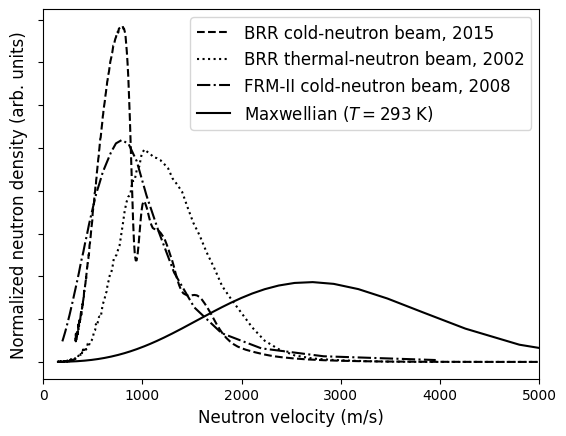

In [5]:
# Define and plot neutron velocity distributions from energy spectra
def p(vn, phi, T=293):
    p_array = []
    for i in range(len(vn)):
        vt = np.sqrt(2 * kB * T / m_n)
        p_array.append(2 * vt * phi[i] / (np.sqrt(np.pi) * vn[i]))
    N = trapezoid(np.array(p_array), vn)  # Normalization factor, to ensure integral of p(T,v) integrates to 1 (Molnar p. 12)
    return np.array(p_array)/N

# Import BRR and FRM-II neutron spectra
En_BRR_thermal, dndE_BRR_thermal = gw.import_spectrum('/Users/davidmatters/westcott/spectra/csv/bnc_thermal_spectrum_2002.csv')
En_BRR_cold, dndE_BRR_cold = gw.import_spectrum('/Users/davidmatters/westcott/spectra/csv/bnc_cold_spectrum_2015.csv')
En_FRM_cold, dndE_FRM_cold = gw.import_spectrum('/Users/davidmatters/westcott/spectra/csv/frm-ii_cold_spectrum_2008.csv')

# Plot BRR and FRM-II distributions against Maxwellian
p_BRR_cold = p(gw.vel(En_BRR_cold), dndE_BRR_cold)
p_BRR_thermal = p(gw.vel(En_BRR_thermal), dndE_BRR_thermal)
p_FRM_cold = p(gw.vel(En_FRM_cold), dndE_FRM_cold)

p_Maxwellian_21 = gw.phi_Maxwellian(21, gw.vel(En_BRR_thermal))
p_Maxwellian_140 = gw.phi_Maxwellian(140, gw.vel(En_BRR_thermal))
p_Maxwellian_293 = gw.phi_Maxwellian(293, gw.vel(En_BRR_thermal))

plt.plot(gw.vel(En_BRR_cold), p_BRR_cold, color='k', linestyle='dashed')
plt.plot(gw.vel(En_BRR_thermal), p_BRR_thermal, color='k', linestyle='dotted')
plt.plot(gw.vel(En_FRM_cold), p_FRM_cold, color='k', linestyle='dashdot')

#plt.plot(gw.vel(En_BRR_thermal), p_Maxwellian_21, color='k', linestyle='solid')
#plt.plot(gw.vel(En_BRR_thermal), p_Maxwellian_140, color='k', linestyle='solid')
plt.plot(gw.vel(En_BRR_thermal), p_Maxwellian_293, color='k', linestyle='solid')

ax = plt.gca()
ax.set_xlim([0,5000])
#ax.set_yscale('log')
plt.xlabel(r"Neutron velocity (m/s)", size = 12)
plt.ylabel(r"Normalized neutron density (arb. units)", size = 12)
ax.axes.yaxis.set_ticklabels([])
#plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend([r"BRR cold-neutron beam, 2015", r"BRR thermal-neutron beam, 2002", r"FRM-II cold-neutron beam, 2008", r"Maxwellian ($T=293$ K)"], loc='best', prop={'size':12})
plt.show()
#plt.savefig('spectra.pdf', bbox_inches='tight')
#plt.savefig('spectra.eps', bbox_inches='tight')

In [6]:
# Compare BNC (2002 & 2015) and Maxwellian values for several non-1/v nuclei
isotopes_comparison = ['S36', 'Kr83', 'In115', 'Sm149', 'Eu151', 'Gd155', 'Lu176', 'Re185', 'Au197']

# Build LaTeX table
print("\\begin{table*}[!t]")
print("\\centering{}\\caption{Comparison of Westcott $g$ factors for select non-$1/v$ nuclei using Maxwellian neutron energy distributions and spectra from the Budapest Research Reactor. \\protect\\label{Table:g-factor_comparison}}")
print("\\begin{tabular}{|c|c|c|c|c|}")
print("\\hline")
print("Isotope & g_w(T=140~K)$ & $g_w$, BRR cold spectrum (2015) & $g_w(T=293~K)$ & $g_w$, BRR thermal spectrum (2002) \\\\")
print("\\hline")
for isotope in isotopes_comparison:
    sigma_x, sigma_y = gw.sigma_ENDF(capture_data_PATH, isotope)
    row = f"{format_isotope_latex(isotope)}"
    value = gw.gw_Maxwellian(140, sigma_x, sigma_y)
    row += f" & {value:.3f}"
    value = gw.gw_arbitrary(En_BRR_cold, dndE_BRR_cold, sigma_x, sigma_y)
    row += f" & {value:.3f}"
    value = gw.gw_Maxwellian(293, sigma_x, sigma_y)
    row += f" & {value:.3f}"
    value = gw.gw_arbitrary(En_BRR_thermal, dndE_BRR_thermal, sigma_x, sigma_y)
    row += f" & {value:.3f}"
    print(row + "\\\\")
    print("\\hline")
print("\\end{tabular}")
print("\\end{table*}")

\begin{table*}[!t]
\centering{}\caption{Comparison of Westcott $g$ factors for select non-$1/v$ nuclei using Maxwellian neutron energy distributions and spectra from the Budapest Research Reactor. \protect\label{Table:g-factor_comparison}}
\begin{tabular}{|c|c|c|c|c|}
\hline
Isotope & g_w(T=140~K)$ & $g_w$, BRR cold spectrum (2015) & $g_w(T=293~K)$ & $g_w$, BRR thermal spectrum (2002) \\
\hline
$^{36}$S & 0.975 & 0.869 & 1.054 & 0.915\\
\hline
$^{83}$Kr & 1.000 & 1.003 & 0.995 & 1.000\\
\hline
$^{115}$In & 0.999 & 0.977 & 1.038 & 1.054\\
\hline
$^{149}$Sm & 1.115 & 0.721 & 2.133 & 0.767\\
\hline
$^{151}$Eu & 1.058 & 1.296 & 0.840 & 1.225\\
\hline
$^{155}$Gd & 0.924 & 0.881 & 0.780 & 0.910\\
\hline
$^{176}$Lu & 1.062 & 0.789 & 2.301 & 0.829\\
\hline
$^{185}$Re & 0.999 & 0.994 & 1.009 & 1.030\\
\hline
$^{197}$Au & 1.000 & 0.994 & 1.009 & 1.307\\
\hline
\end{tabular}
\end{table*}


In [21]:
# Compare g-factors calculated using the irregularity method outlined in Molnar text with those from the cross-section integration method
#Lowest-energy resonance parameters for select nuclei from ENDF/B-VIII.1 and Mughabghab's Atlas, to demonstrate irregularity method
class Resonance:
    def __init__(self, isotope, E_resonance, Gamma, data_source):
        self.isotope = isotope
        self.energy = E_resonance
        self.width = Gamma
        self.library = data_source

resonances_ENDF = [
    Resonance('Kr83', -9.81, 3.8400000e-01, 'ENDF'),
    Resonance('Eu151', -0.0609, 0.1052768, 'ENDF'),
    Resonance('Gd157', 0.0314, 0.1072 + 4.74E-04, 'ENDF'),
    Resonance('Re187', -4.03, 7.4371000e-02, 'ENDF')
    ]

resonances_Atlas = [
    Resonance('Kr83', -9.81, 252/1000, 'Atlas'),
    Resonance('Eu151', -0.00362, 95.8/1000, 'Atlas'),
    Resonance('Gd157', 0.0314, 107/1000, 'Atlas'),
    Resonance('Re187', -3.94, 57.8/1000, 'Atlas')
    ]

resonances = resonances_ENDF + resonances_Atlas

def get_resonance_parameters(isotope):
    for resonance in resonances:
        if resonance.isotope == isotope & resonance.library == 'ENDF':
            return(resonance.energy, resonance.width)

for test_isotope in ['Kr83','Eu151','Gd157','Re187']:
    capture_data_PATH = "/Users/davidmatters/westcott/n-capture-gnds/capture_data"
    sigma_x, sigma_y = gw.sigma_ENDF(capture_data_PATH, test_isotope)
    Er_test, Gamma_test = get_ENDF_parameters(test_isotope)
    print(test_isotope)
    print("Temperature (Maxwellian avg.) \t g_w(irregularity method) \t g_w(cs_integration) \t Percent difference")
    for temp in temperatures:
        gw_irreg = gw.gw_irregularity(Er_test, Gamma_test, np.linspace(1,100000,100000), gw.phi_Maxwellian(temp,np.linspace(1,100000,100000)), temp)
        gw_cs_integ = gw.gw_Maxwellian(temp, sigma_x, sigma_y)
        delta_pct = (gw_irreg - gw_cs_integ)/gw_cs_integ * 100
        print("{0} \t\t\t\t {1:.3f} \t\t\t\t {2:.3f} \t\t\t {3:.2f}".format(temp, gw_irreg, gw_cs_integ, delta_pct))
    print('\n')

Kr83
Temperature (Maxwellian avg.) 	 g_w(irregularity method) 	 g_w(cs_integration) 	 Percent difference
20 				 1.005 				 0.995 			 0.95
40 				 1.004 				 0.995 			 0.90
60 				 1.004 				 0.995 			 0.85
80 				 1.003 				 0.995 			 0.79
100 				 1.003 				 0.995 			 0.74
120 				 1.002 				 0.995 			 0.69
140 				 1.001 				 0.995 			 0.63
160 				 1.001 				 0.995 			 0.58
180 				 1.000 				 0.995 			 0.53
200 				 1.000 				 0.995 			 0.48
220 				 0.999 				 0.995 			 0.42
240 				 0.999 				 0.995 			 0.37
260 				 0.998 				 0.995 			 0.32
280 				 0.998 				 0.995 			 0.27
293 				 0.997 				 0.995 			 0.23
300 				 0.997 				 0.995 			 0.22
320 				 0.997 				 0.995 			 0.16
340 				 0.996 				 0.995 			 0.11
360 				 0.996 				 0.995 			 0.06
380 				 0.995 				 0.995 			 0.01
400 				 0.995 				 0.995 			 -0.04
420 				 0.994 				 0.995 			 -0.10
440 				 0.994 				 0.995 			 -0.15
460 				 0.993 				 0.995 			 -0.20
480 				 0.993 				 0.995 			 -0.25
500 				 0.992 				

KeyboardInterrupt: 